# IMPORT

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import arrow

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

from scipy.stats import boxcox
from scipy.stats import yeojohnson, uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from pprint import pprint
import featuretools as ft

/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv


# USEFUL FUNCTIONS

In [23]:
def draw_importancy(df):
    """Function that draws features importancy for both continous and categorical features"""
    i = 0
    continous_all = continous + ['app_date_std']
    fig, axes = plt.subplots(1, 2, figsize=(20, 10));
    for data in [df, clean_outs(df)]:
        """to see if there is any difference for dataset with and without outliers"""
        imp_num = Series(f_classif(data[continous_all], data['default'])[0], index = continous_all)
        imp_num.sort_values(inplace = True)
        imp_num.plot(kind = 'barh', ax = axes[i])
        i+=1
    plt.show()
    
    i = 0
    fig, axes = plt.subplots(1, 2, figsize=(20, 10));
    for data in [df, clean_outs(df)]:
        """Categorical features. Same, with and without outliers"""
        imp_cat = Series(mutual_info_classif(data[binary + categorical], data['default'],
                                         discrete_features = True), index = binary + categorical)
        imp_cat.sort_values(inplace = True)
        imp_cat.plot(kind = 'barh', ax = axes[i])
        i+=1
    plt.show()

def clean_outs(df):
    """Function cleaning all the outliers in numerical data"""
    df_copy = df
    stats = df.describe()
    iqr = stats.loc['75%']-stats.loc['25%']
    for feature in continous:
        try:
            criteria_25 = stats.loc['25%', feature] - iqr[feature]*1.5
            criteria_75 = stats.loc['75%', feature] + iqr[feature]*1.5
            df_copy = df_copy[df_copy[feature] >= criteria_25]
            df_copy = df_copy[df_copy[feature] <= criteria_75]
        except: continue    
    return df_copy

def predict_probs(model, x_t):
    probs = model.predict_proba(x_t)
    return probs[:,1]

def draw_roc_auc(test, probs):
    fpr, tpr, threshold = roc_curve(test, probs)
    roc_auc = roc_auc_score(test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Model ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

# DATA

In [24]:
df = pd.read_csv('../input/sf-dst-scoring/train.csv')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

307 values are empty for 'education' feature.
To be filled by 'no_data' value

In [26]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [27]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [28]:
# Features division on continous, categorical(non-binary) and binary
continous = ['age','score_bki', 'bki_request_cnt','decline_app_cnt', 'income']
categorical = ['home_address', 'work_address', 'sna', 'first_time', 'region_rating']
binary = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

_App_date_ and _education_ are standing apart.
_Education_ needs to be encoded separately as non-binary and non-numerical. _App_date_ can be somehow processed in continous and than scaled. Also it can be used as basis for some further feature engineering

In [29]:
len(set(df.client_id)) == len(df)
# Each of the client ID's is met only once in this dataset

True

# DATA CLEANING AND PREPARATION

In [30]:
def prepare_data(df_old):
    """Function wrapping all the cleansing and preparation for ML"""
    continous = ['age','score_bki', 'bki_request_cnt','decline_app_cnt', 'income']
    categorical = ['home_address', 'work_address', 'sna', 'first_time', 'region_rating']
    binary = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
    shifted = ['income', 'age', 'bki_request_cnt', 'decline_app_cnt']
    #continous features with strong tails
    
    df_new = df_old
    
    df_new.education.fillna('no_data', inplace=True)
    
    for col in shifted:
        """Shifted distribution treatment, """
        df_new[col] = yeojohnson(df_new[col])[0]
    
    label_encoder = LabelEncoder()
    """Encoding binary features from objects to numbers"""
    for column in binary:
        df_new[column] = label_encoder.fit_transform(df_new[column])
    
    """Non-binary education and region_rating features encoding"""
    df_new['education'] = label_encoder.fit_transform(df_new['education'])
    df_new['region_rating'] = label_encoder.fit_transform(df_new['region_rating'])
    
    """App_date converted to timestamp"""
    df_new['app_date'] = df_new.app_date.apply(lambda x: pd.to_datetime(x, format = '%d%b%Y'))
    df_new['app_date_std'] = df_new.app_date.apply(lambda x: arrow.get(x).timestamp)
    df_new['app_date_std'] = df_new.app_date_std.apply(lambda x: (x - df_new.app_date_std.mean()) / df_new.app_date_std.std())

    """Feature engineering"""
    df_new['f1'] = df_new['score_bki']*df_new['region_rating']
    df_new['f2'] = df_new['score_bki']*df_new['income']
    df_new['month'] = df_new.app_date.apply(lambda x: x.month)
    by_day = df_new.groupby('app_date').count()
    means_day = df_new.groupby('app_date').mean()
    sum_day = df_new.groupby('app_date').mean()
    by_month = df_new.groupby('month').count()
    df_new['cl_per_day'] = df_new.app_date.apply(lambda x: by_day.loc[x,'client_id'])
    df_new['cl_per_month'] = df_new.month.apply(lambda x: by_month.loc[x,'client_id'])
    df_new['md_ratio'] = df_new['cl_per_day'] / df_new['cl_per_month']
    df_new['cars_by_day'] = df_new.app_date.apply(lambda x: sum_day.loc[x,'car_type'])
    df_new['pass_by_day'] = df_new.app_date.apply(lambda x: sum_day.loc[x,'foreign_passport'])
    df_new['gw_by_day'] = df_new.app_date.apply(lambda x: sum_day.loc[x,'good_work'])
    df_new['inc_ratio'] = df_new.apply(lambda x: x.income/means_day.loc[x.app_date, 'income'], axis = 1)
    df_new['score_bki_ratio'] = df_new.apply(lambda x: x.income/means_day.loc[x.app_date, 'score_bki'], axis = 1)
    df_new['lux'] = df_new.apply(lambda x: x.good_work & x.car_type & x.foreign_passport, axis = 1)
    df_new['lux_least'] = df_new.apply(lambda x: x.good_work | x.car_type | x.foreign_passport, axis = 1)
    
    df_new.drop('cl_per_month', axis = 1, inplace = True)
    
    for col in shifted:
        """Shifted distribution treatment, """
        df_new[col] = yeojohnson(df_new[col])[0]
    
    return df_new


    
def get_train_part(X):
    X_cat = OneHotEncoder(sparse = False).fit_transform(X[categorical].values)
    X_num = StandardScaler().fit_transform(X[continous].values)
    X_new = np.hstack([X_num, X[binary].values, X_cat])
    return(X_new)



In [20]:
df = prepare_data(df)

In [21]:
continous += ['f1', 'f2', 'cl_per_day', 'md_ratio', 'cars_by_day', 'pass_by_day', 'gw_by_day', 'inc_ratio', 'score_bki_ratio']
categorical += ['month']
binary += ['lux', 'lux_least']

# EDA

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73799 non-null  int64         
 3   sex               73799 non-null  int64         
 4   age               73799 non-null  float64       
 5   car               73799 non-null  int64         
 6   car_type          73799 non-null  int64         
 7   decline_app_cnt   73799 non-null  float64       
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  float64       
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

First of all let's take a look on target value distribution. How balanced is the data.

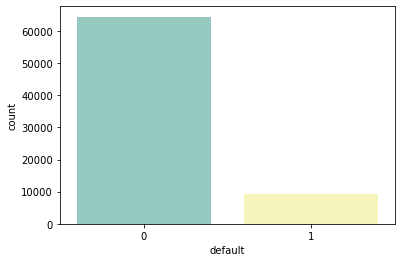

In [23]:
ax = sns.countplot(x = 'default', data = df, palette="Set3")

The data is inbalanced. The most of the client don't have "default", which is difficult data for us, since we don't want to get a lot of false negatives.

Let's take a look on numerical features distribution:

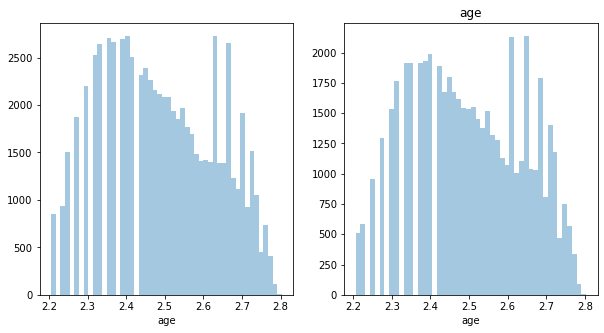

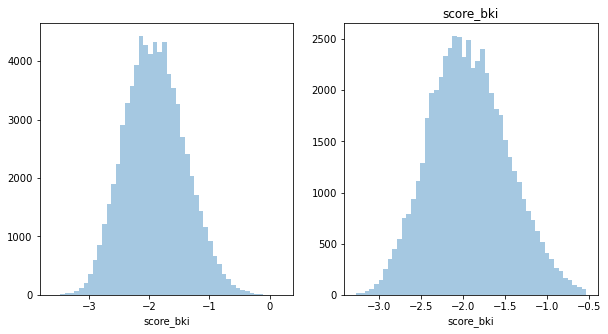

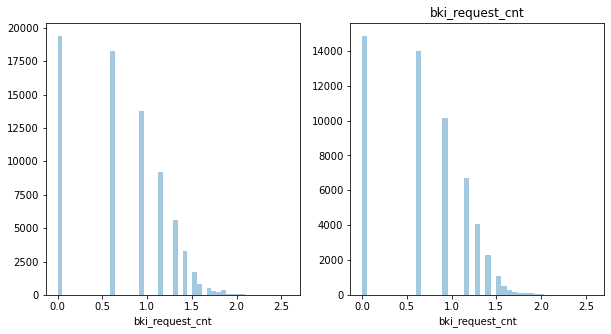

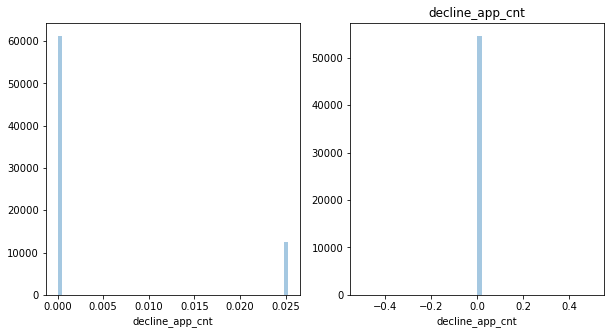

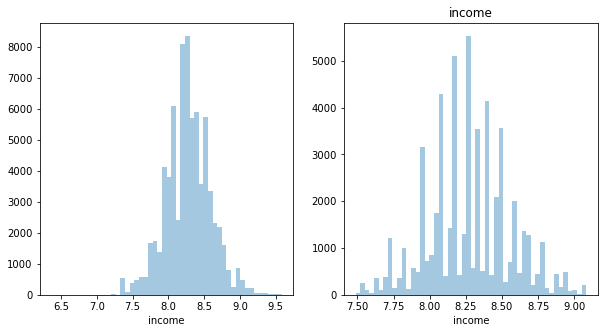

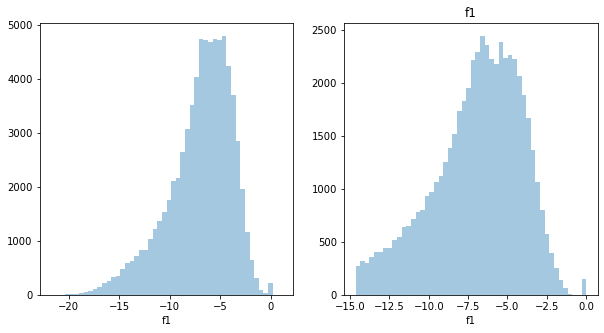

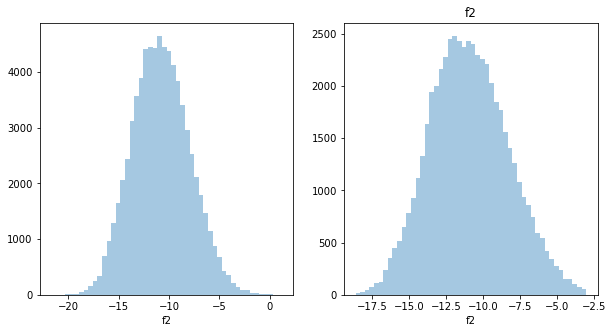

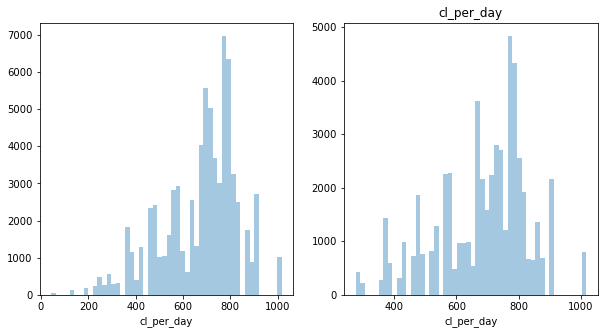

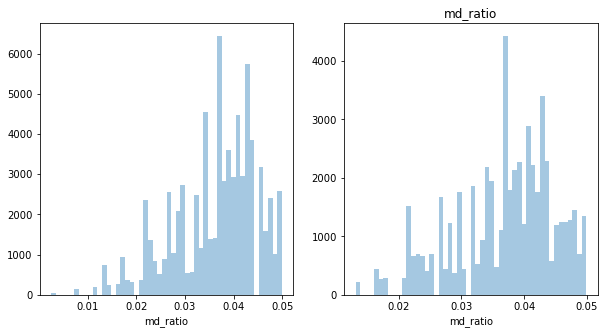

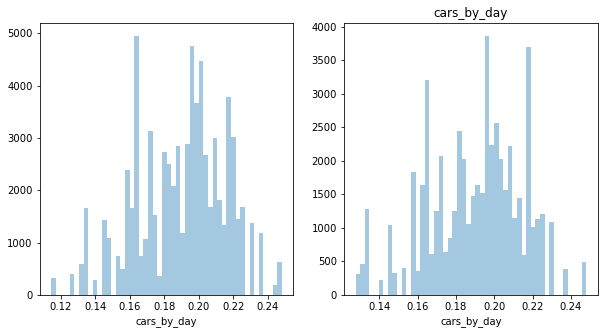

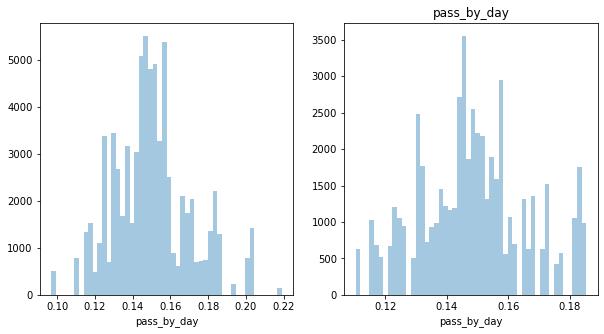

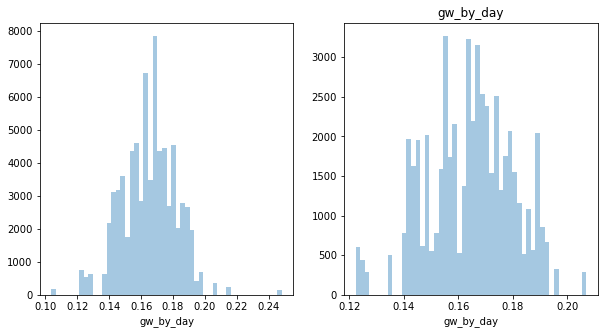

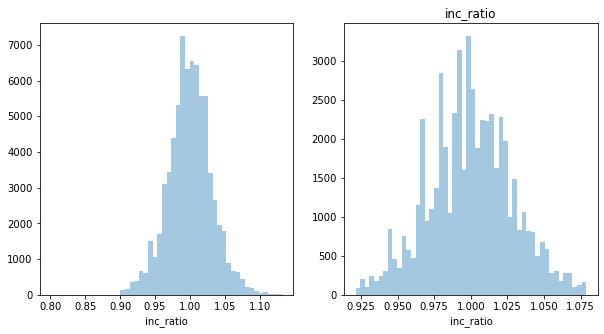

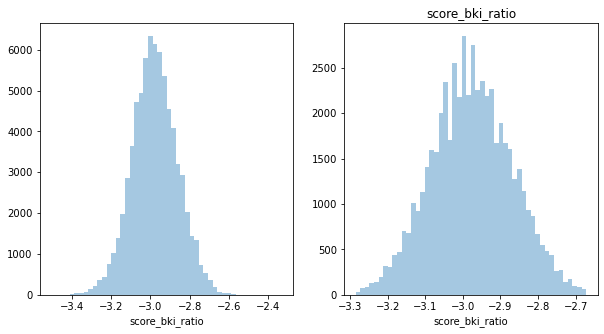

In [24]:

for i in continous:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5));
    sns.distplot(df[i], kde = False, rug=False, ax = axes[0])
    sns.distplot(clean_outs(df)[i], kde = False, rug=False, ax = axes[1])
    plt.title(i)
    plt.show()

**Income, age, bki_request** and **decline_app_cnt** have strong right tail. Region rating shall be re-considered as categorical data.
Shifted features are needed to be logarithmized.

Let's see the distribution of amount of "default" decisions during the time.


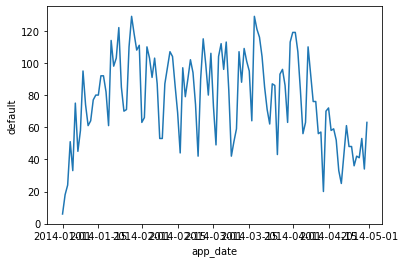

In [25]:
default_cnt = df.groupby(by = 'app_date', sort = True).sum()
sns.lineplot(x=default_cnt.index, y = default_cnt.default)

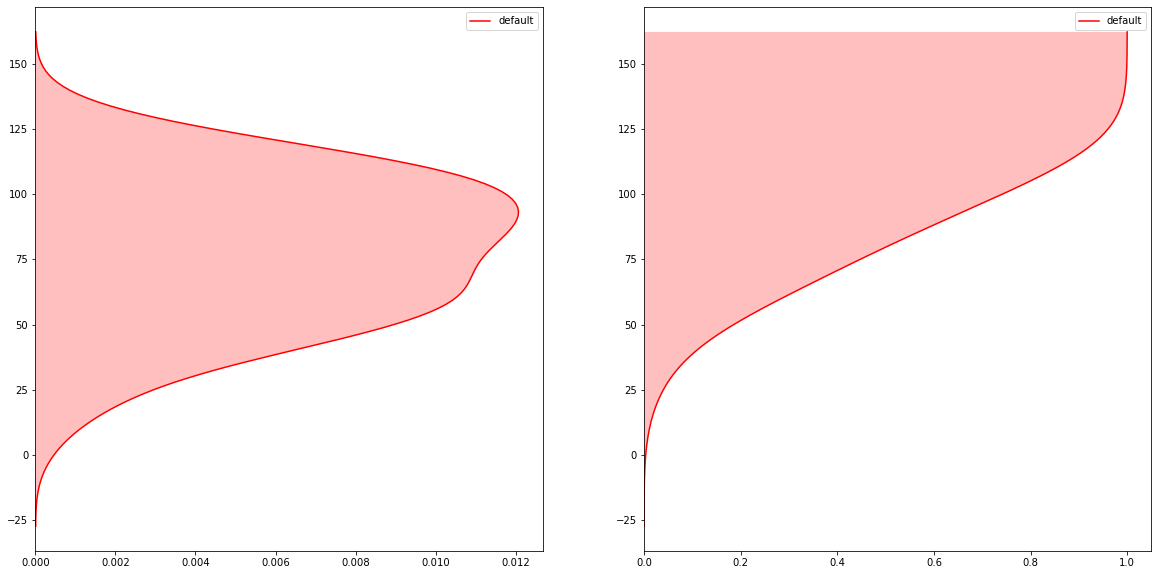

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10));
sns.kdeplot(default_cnt.default, shade=True, color="r", vertical = True, ax = axes[0])
sns.kdeplot(default_cnt.default, shade=True, color="r", cumulative = True, vertical = True)

It appears that the bank developed the scoring system for a while, then improved and became more confident in the issue of loans.

Let's see the boxplots for various continous features for data with(left) and without(right) outliers:

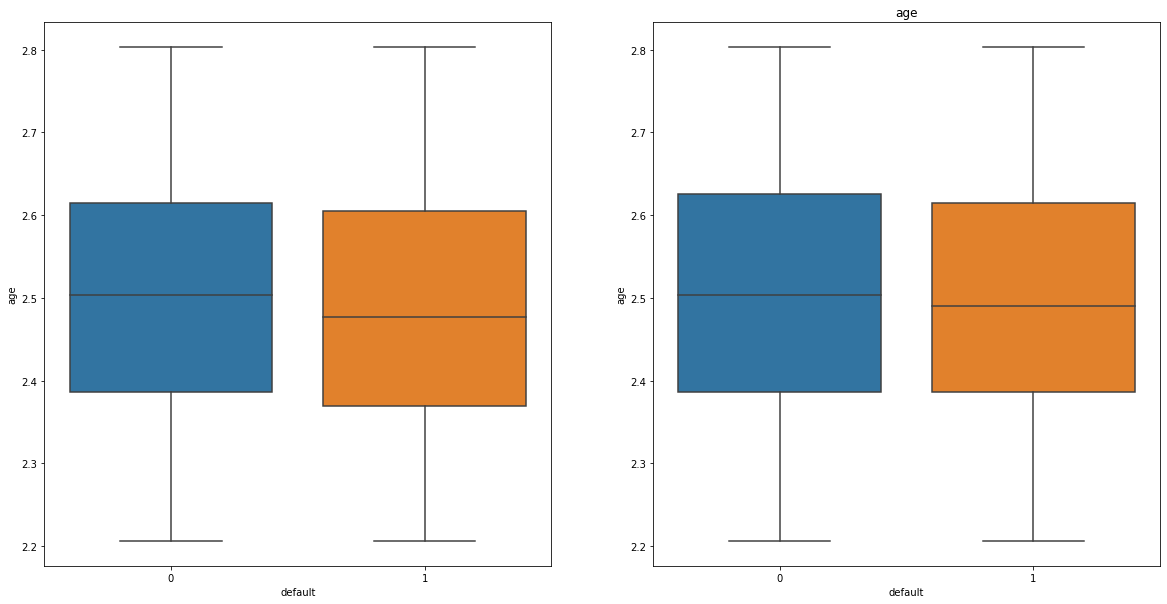

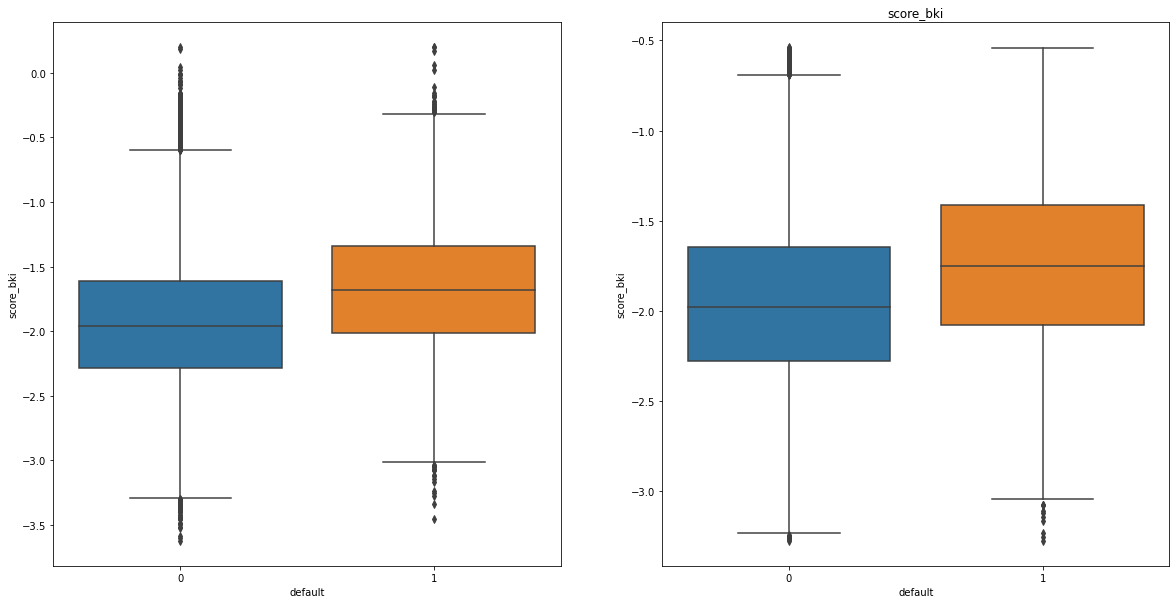

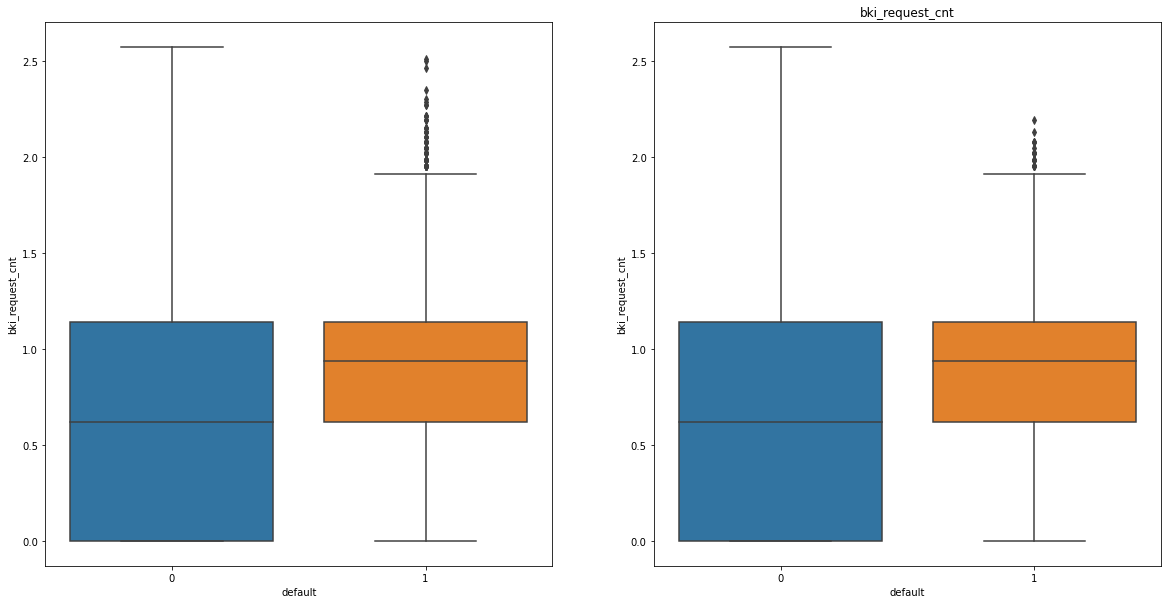

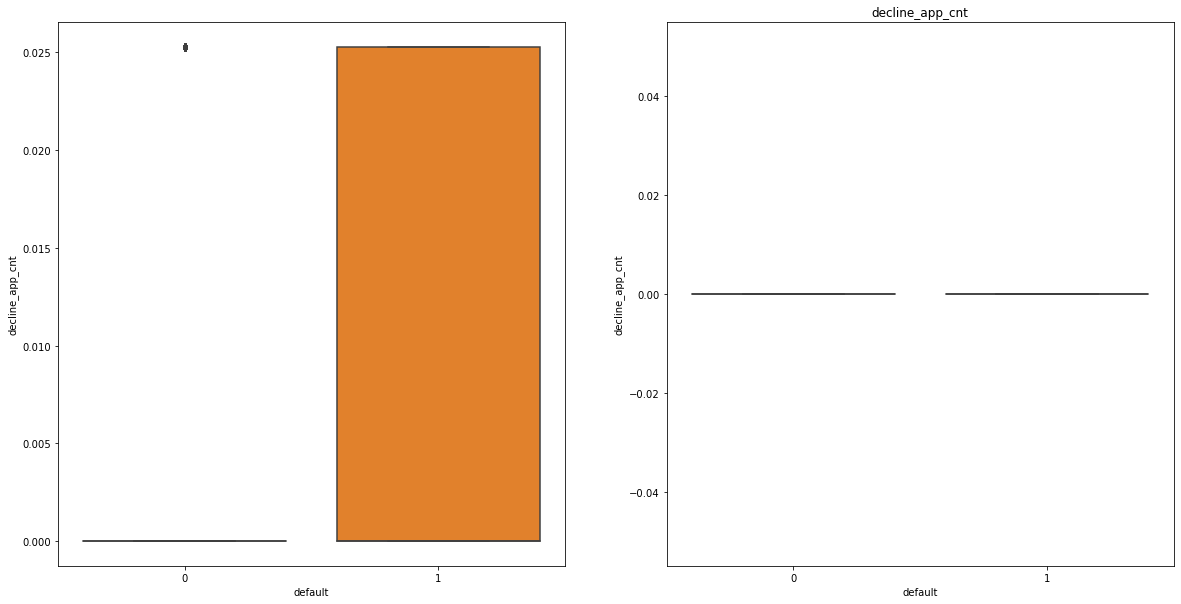

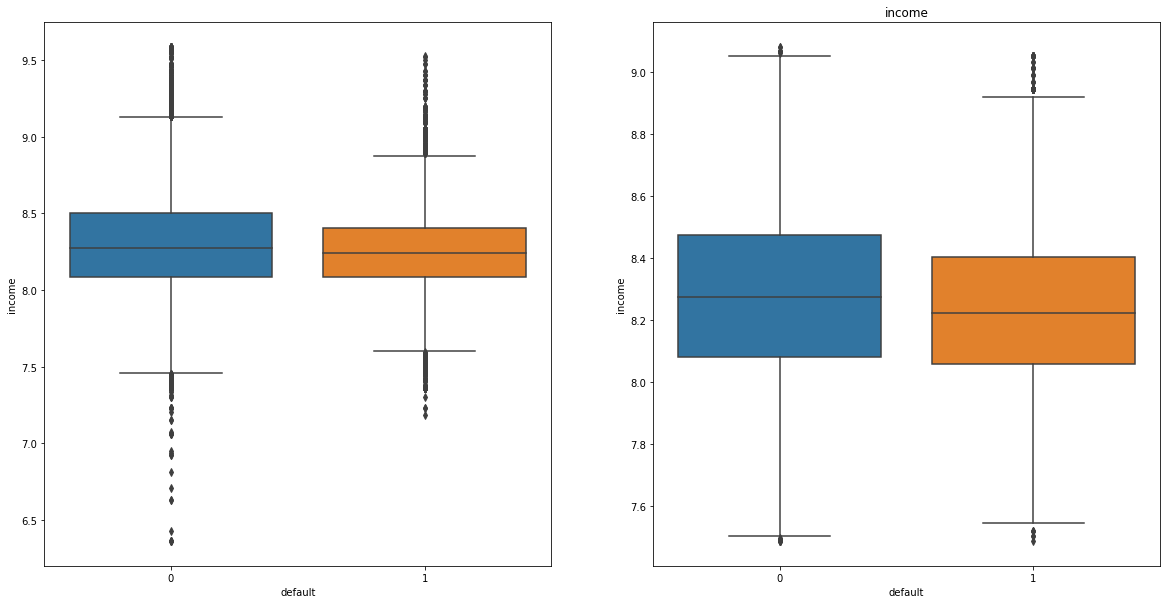

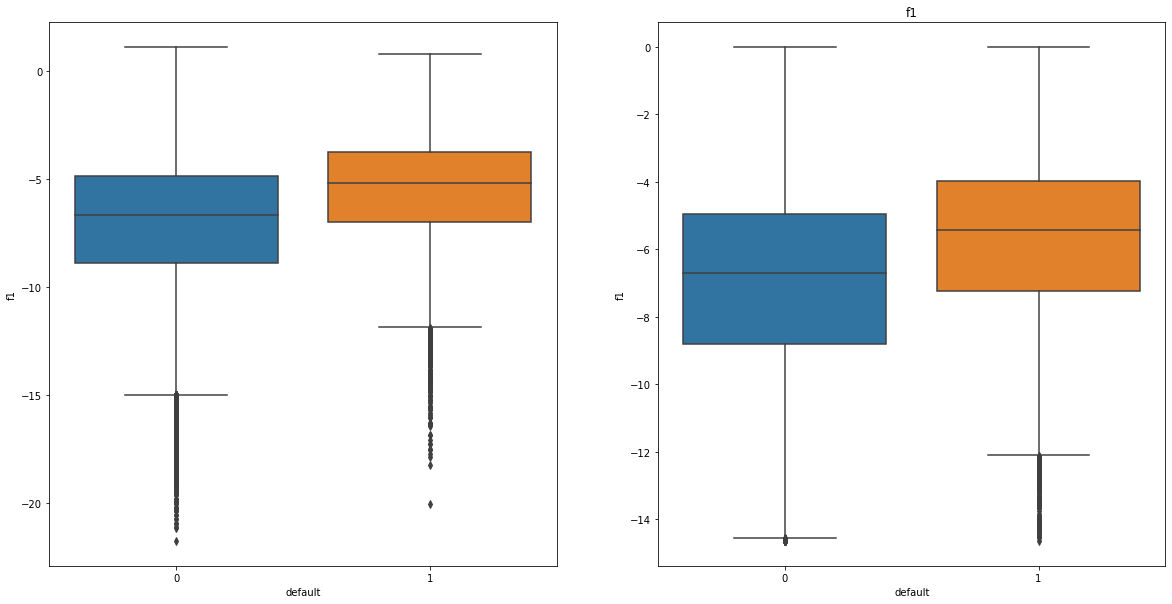

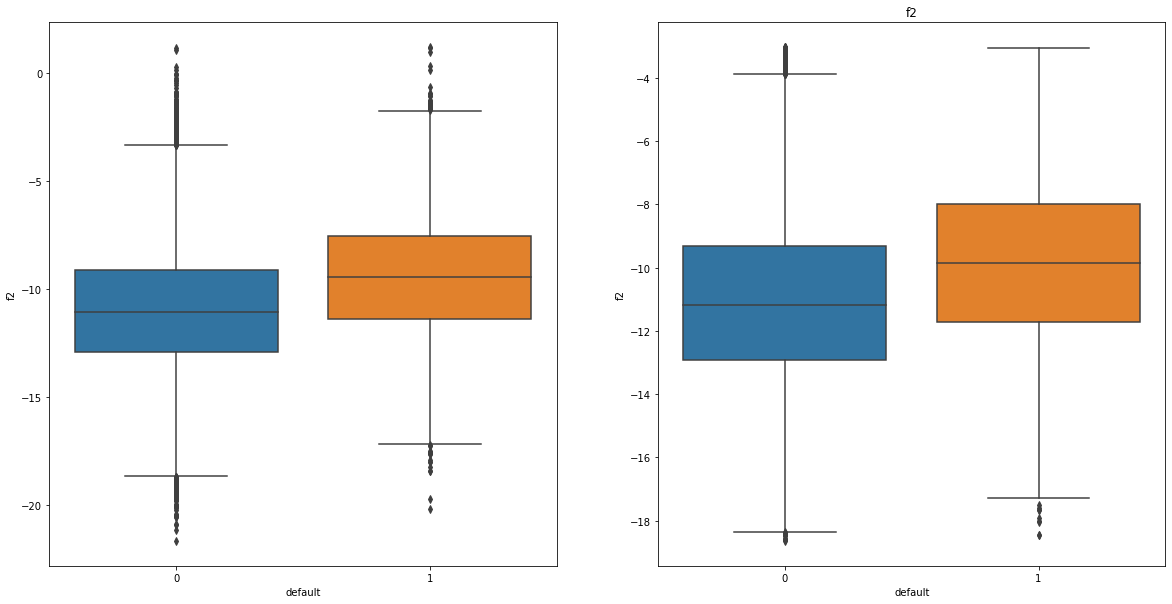

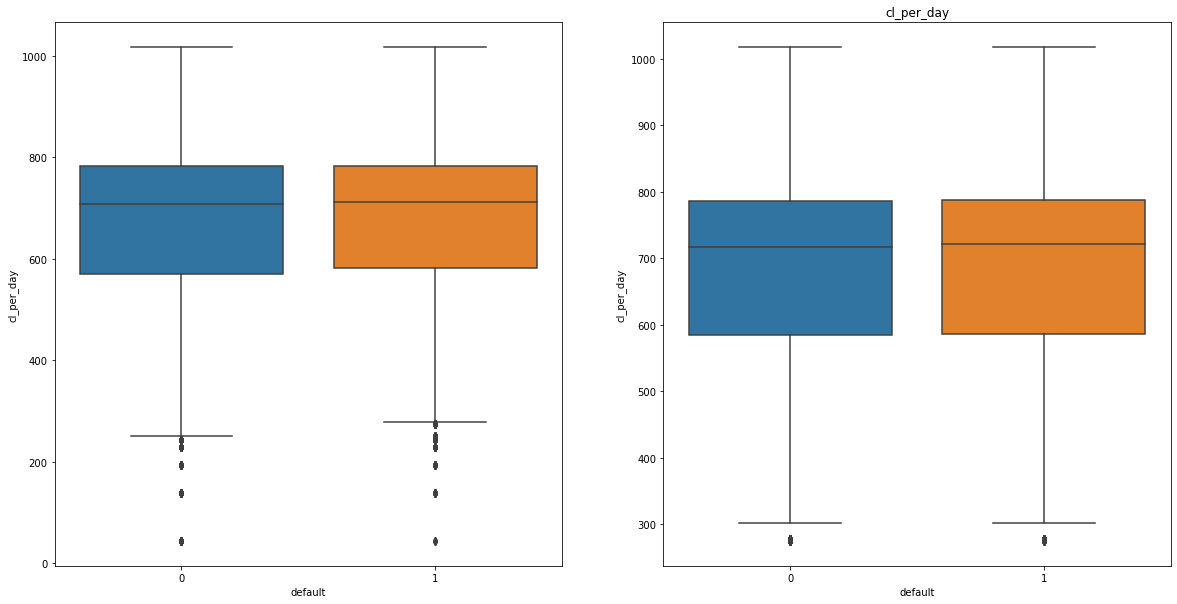

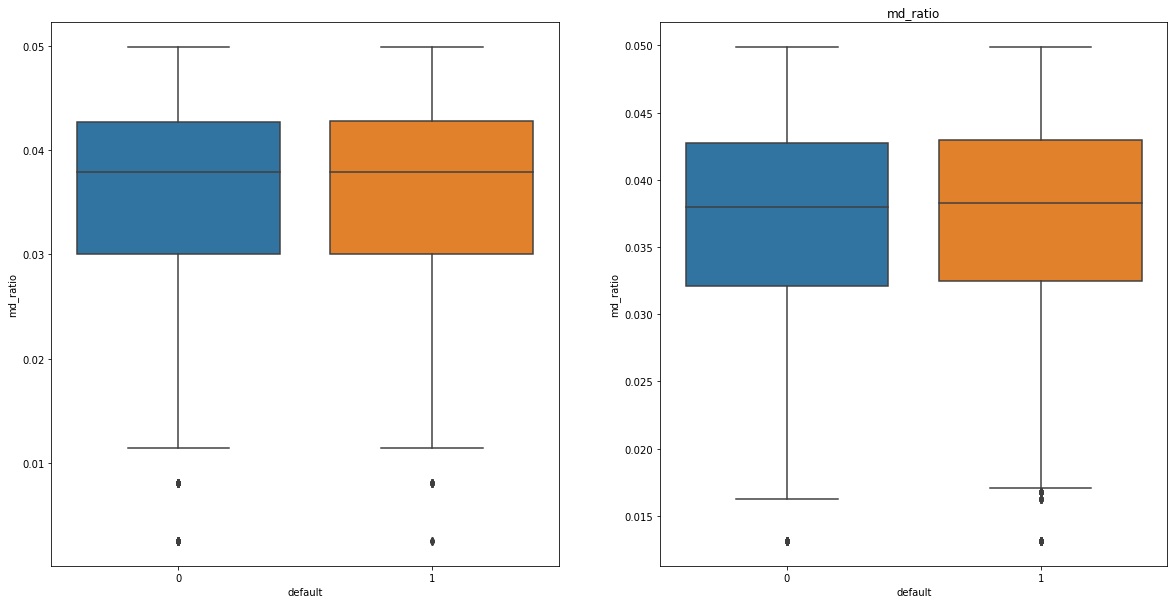

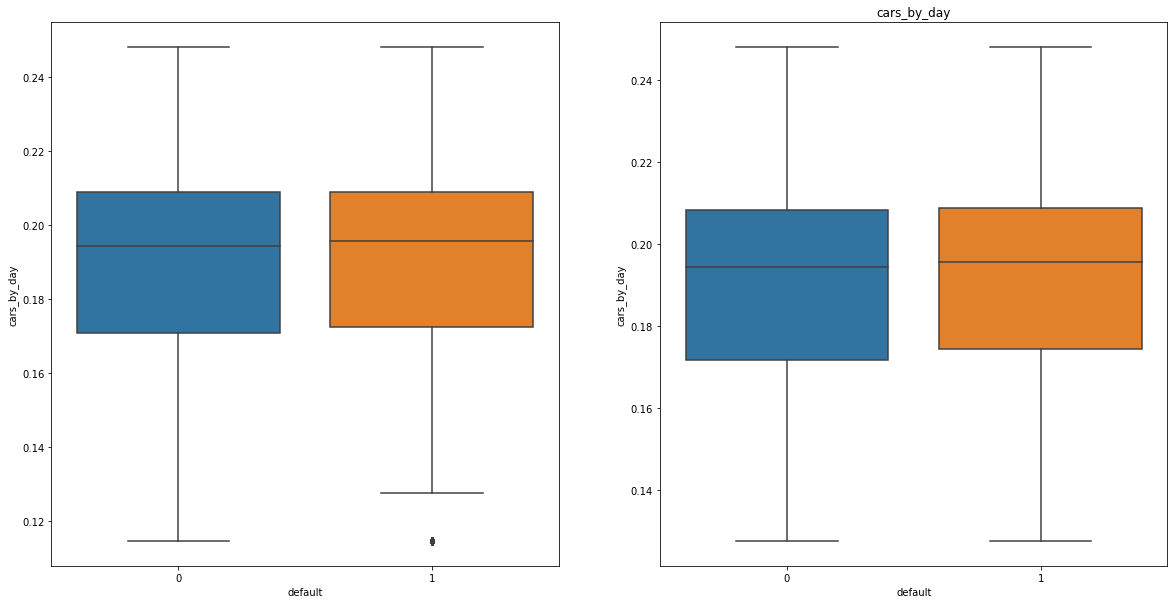

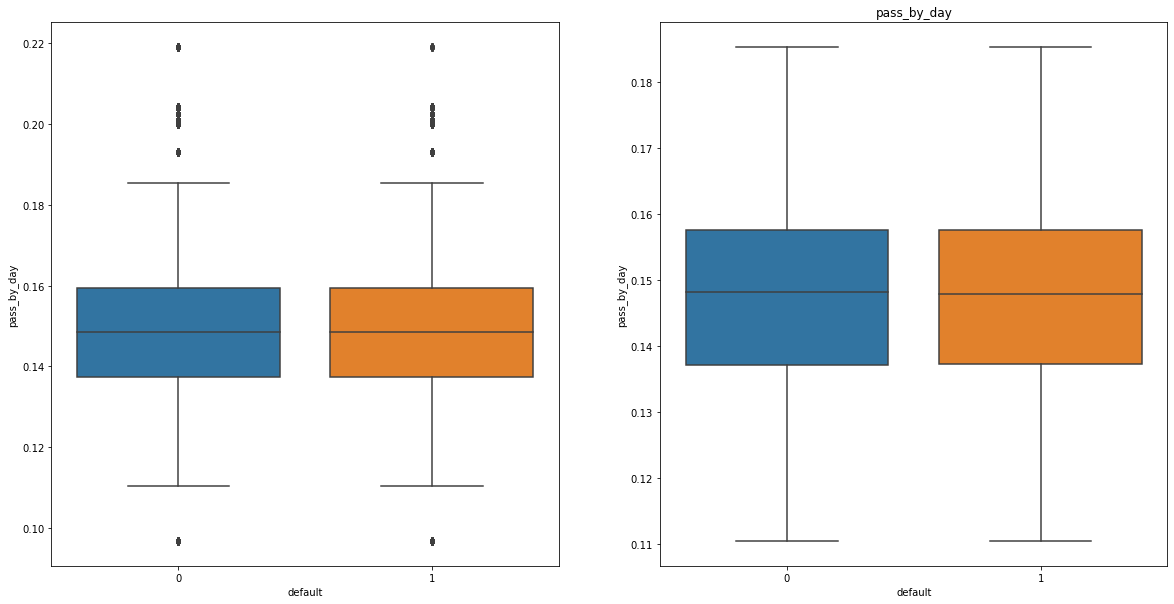

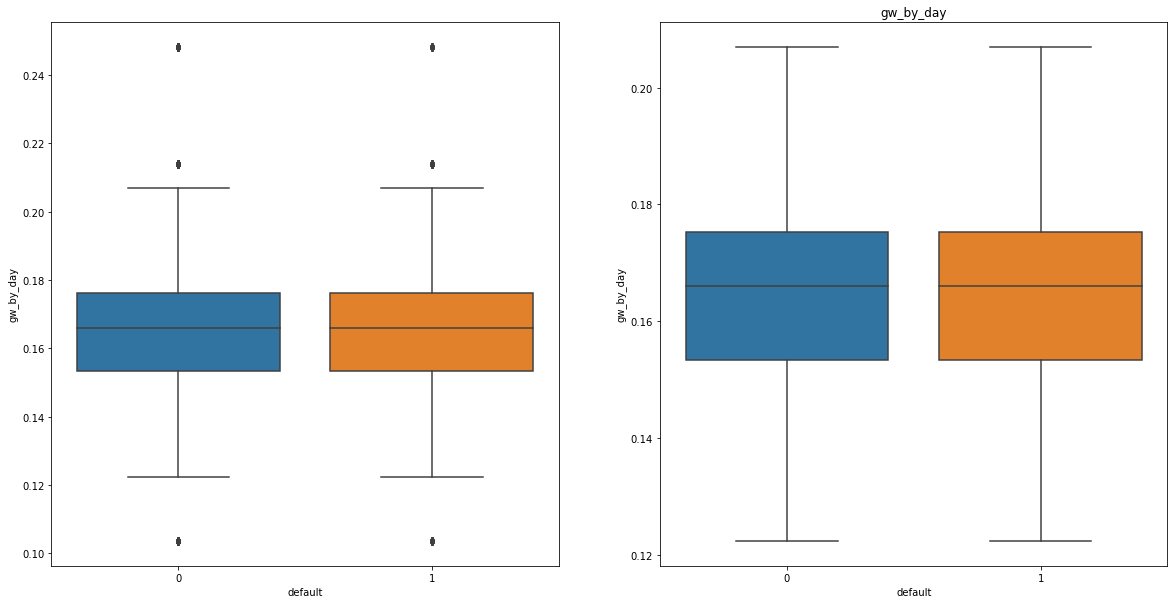

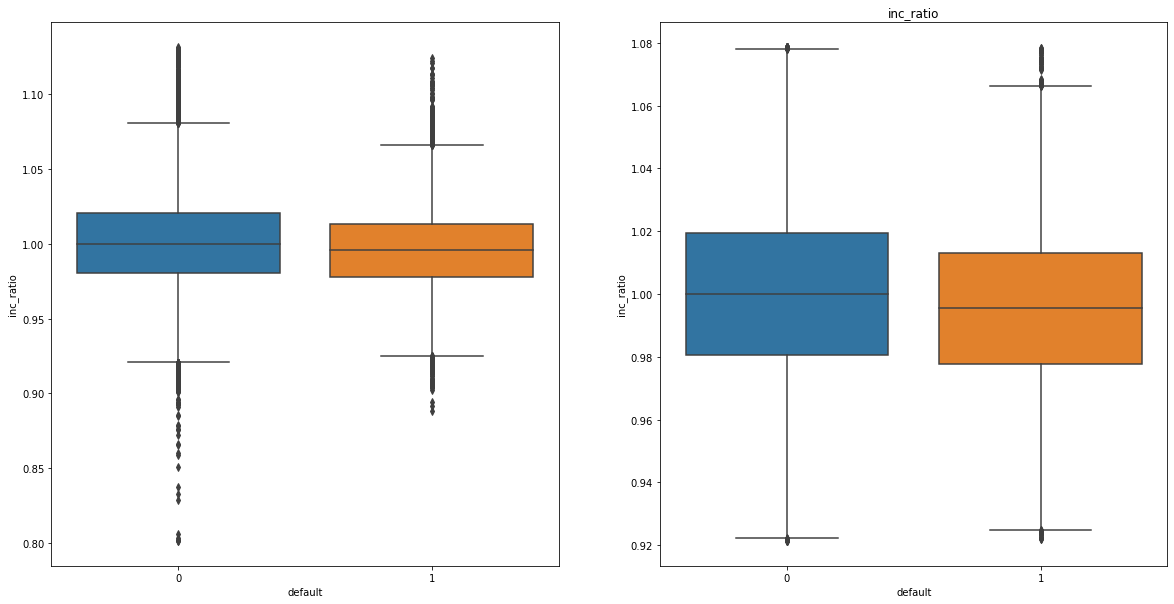

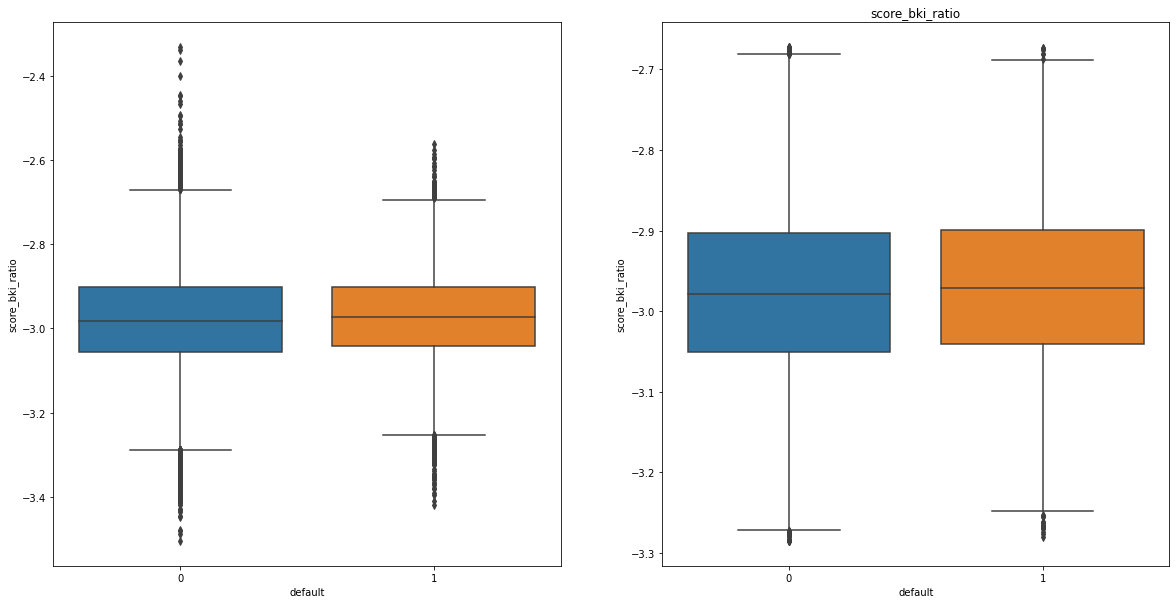

In [27]:
for i in continous:
    fig, axes = plt.subplots(1, 2, figsize=(20, 10));
    sns.boxplot(x='default', y = i, data = df, ax = axes[0])
    sns.boxplot(x='default', y = i, data = clean_outs(df), ax = axes[1])
    plt.title(i)
    plt.show()

It seems that all of non-zero values in decline_app_cnt are considered as outliers, which was noticeable as well in ".describe" table. 

Let's see the correlation matrix of the continous features:


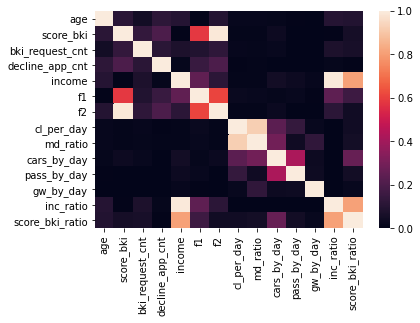

In [28]:
sns.heatmap(df[continous+['app_date']].corr().abs(), vmin=0, vmax=1)

Apart from synthetic features, nothing to worry about. It might be necessary to avoid multicollinear features in linear models.  
Let's see the importancy of the continuous features:

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [3] are constant.
  UserWarning)


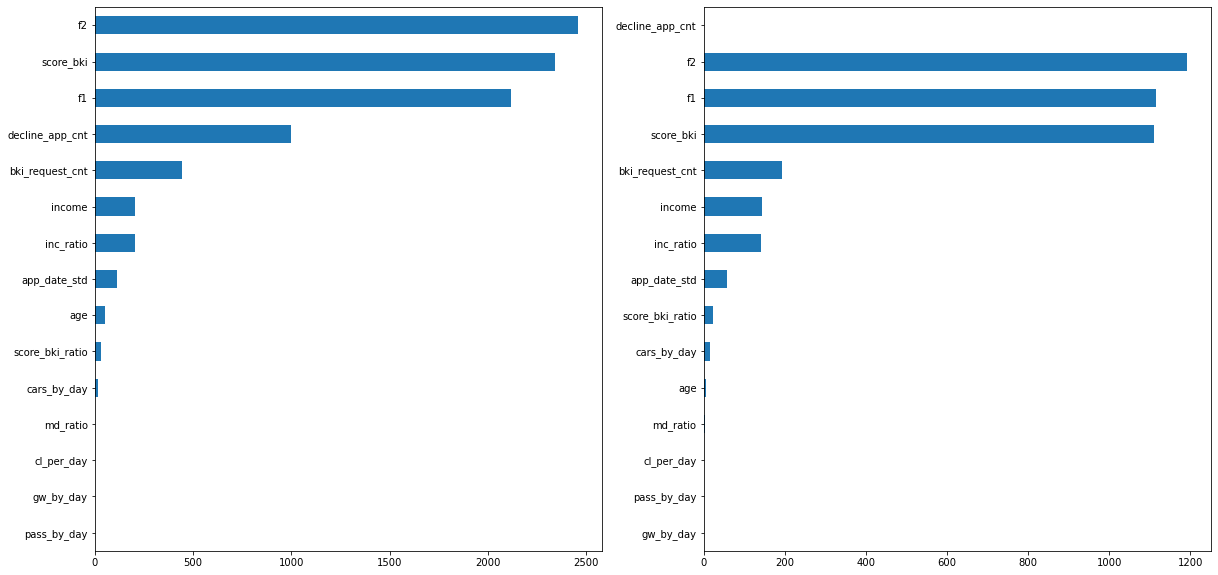

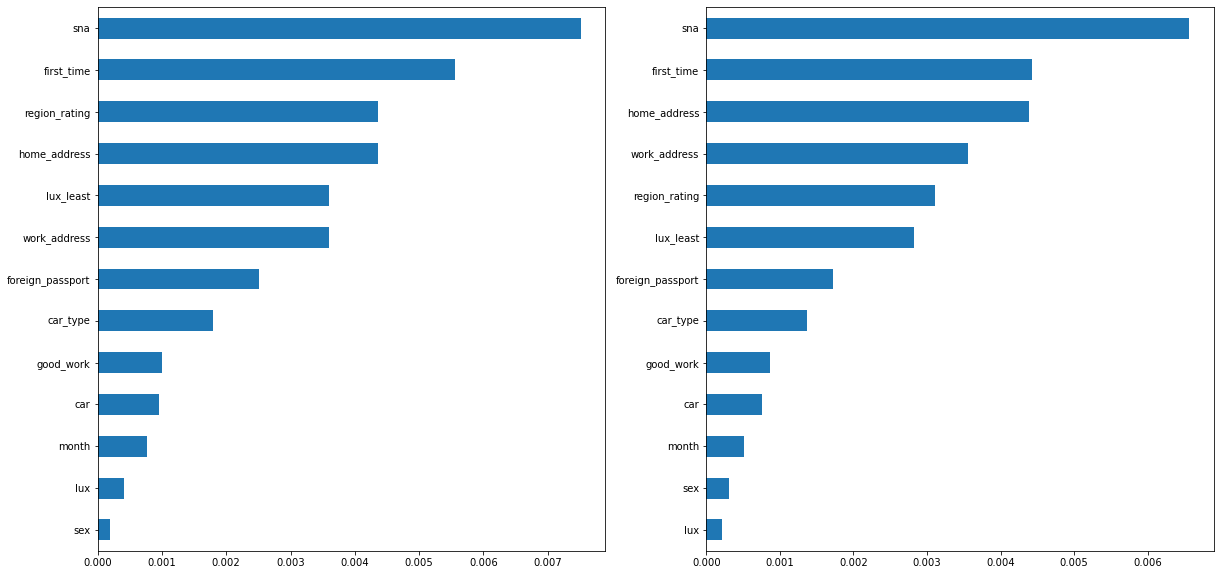

In [29]:
draw_importancy(df)

# DATA PREPROCESSING

In [31]:
#Let's import everything one more time
df_train = pd.read_csv('../input/sf-dst-scoring/train.csv')
df_test = pd.read_csv('../input/sf-dst-scoring/test.csv')

#We need to combine train and test to preprocess them equally
df_train['sample'] = 1 # train
df_test['sample'] = 0 # test
df_test['default'] = 0 # target value

data = df_test.append(df_train, sort=False).reset_index(drop=True) # combining...
data.info()
df_pr = prepare_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [32]:
continous += ['f1', 'f2', 'cl_per_day', 'md_ratio', 'cars_by_day', 'pass_by_day', 'gw_by_day', 'inc_ratio', 'score_bki_ratio']
categorical += ['month']
binary += ['lux', 'lux_least']

In [33]:
train_data = df_pr.query('sample == 1').drop(['sample'], axis=1)
test_data = df_pr.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values            # target
X = train_data.drop(['client_id','default', 'app_date'], axis=1)
X = get_train_part(X)

In [34]:
train_data.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Train data is still quiet imbalanced, we need to add some synthetic samples. We'll try to use SMOTE.

# Hyperparameters Searching and ML

Лучшее Penalty: l2
Лучшее C: 1291.5496650148827


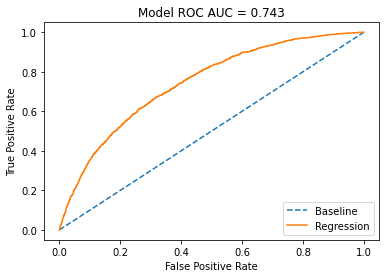

In [38]:
from sklearn.model_selection import GridSearchCV

#Finding the best C and penalty for Logistic Regression by GridSearchCV

# Types of penalties
penalty = ['l1', 'l2']

# Threshold for regularisation parameter
C = np.logspace(0, 4, 10)

# Hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver='liblinear', tol=1e-2, max_iter=200, class_weight = 'balanced',
                               random_state=42)
model.fit(X_train, y_train)

# Search grid with 5x cross-validation
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring = 'roc_auc')

best_model = clf.fit(X, y)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

draw_roc_auc(y_test, predict_probs(best_model, X_test))
# kf = KFold(n_splits=10)
# cross_val_score(best_model, X, y, cv=kf, scoring="roc_auc")

In [62]:
#Best C and penalty by RandomizedSearchCV
logistic = LogisticRegression(tol=1e-2, max_iter=200, class_weight = 'balanced',
                               random_state=42)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'],
                     solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     class_weight = ['balanced', None])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X, y)
print(search.best_params_)

# kf = KFold(n_splits=5)
# cross_val_score(search, X, y, cv=kf, scoring="roc_auc")

{'C': 2.195254015709299, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'}


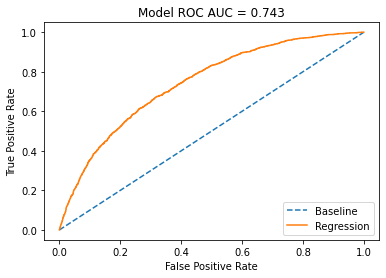

In [45]:
draw_roc_auc(y_test, predict_probs(search, X_test))

In [58]:
# Random Forest Learning (hyperparameters were estimated by teammate)
RForest = RandomForestClassifier(n_estimators = 400,
 min_samples_split = 2,
 min_samples_leaf= 4,
 max_features = 'sqrt',
 max_depth = 10,
 class_weight = 'balanced')
RForest.fit(X, y)
    

# # DecisionTreeClassifier Learning (denied as lower rated)
# dtc = DecisionTreeClassifier(random_state=42, max_depth=10)
# dtc.fit(X_train, y_train)
# probs_dtc = predict_probs(dtc, X_test)

# # Bagging Learning (denied as lower rated)
# bcl = BaggingClassifier(random_state=42, n_estimators=1500)
# bcl.fit(X_train, y_train)
# probs_bcl = predict_probs(bcl, X_test)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', min_samples_leaf=4,
                       n_estimators=400)

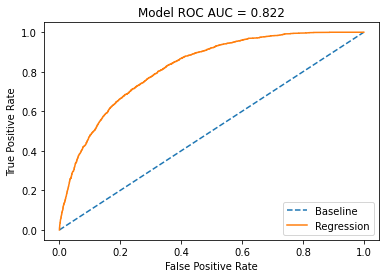

In [61]:
draw_roc_auc(y_test, predict_probs(RForest, X_test))

SMOTE augmentation

In [ ]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_sample(X, y)

#Logistic Regression Learning trained on augmented data
lr_sm = LogisticRegression(penalty = 'l2', C = 454.16)
lr_sm.fit(X_sm, y_sm)
lr_prob_sm = predict_probs(lr_sm, X_test)
draw_roc_auc(y_test, lr_prob_sm)

In [ ]:
kf = KFold(n_splits=5)
print(cross_val_score(lr_sm, X, y, cv=kf, scoring="roc_auc"))

In [ ]:
#Random Forest Classifier best hyperparameters estimation
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199),
    'class_weight': [None, 'balanced']
}

# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=100, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train, y_train)

# print winning set of hyperparameters
pprint(model.best_estimator_.get_params())

In [ ]:
draw_roc_auc(y_test, predict_probs(search, X_test))

# Submission

In [46]:
test_data = test_data.drop(['default','app_date'], axis=1)

KeyError: "['default' 'app_date'] not found in axis"

In [54]:
predict_submission = search.predict_proba(get_train_part(test_data))
predict_submission

array([[0.95592988, 0.04407012],
       [0.76666674, 0.23333326],
       [0.91872326, 0.08127674],
       ...,
       [0.73699986, 0.26300014],
       [0.70240361, 0.29759639],
       [0.83873912, 0.16126088]])

In [55]:
for_ids = pd.read_csv('../input/sf-dst-scoring/test.csv')

In [56]:
sample_submission = pd.DataFrame(columns = ['client_id','default'])
sample_submission['client_id'] = for_ids.client_id
sample_submission['default'] = 1 - predict_submission #magic
sample_submission

,client_id,default
0,74835,0.044070
1,17527,0.233333
2,75683,0.081277
3,26883,0.065797
4,28862,0.033239
...,...,...
36344,83775,0.363011
36345,106254,0.038433
36346,81852,0.263000
36347,1971,0.297596


In [57]:
sample_submission.to_csv('submission.csv', index=False)